In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import load_model
import pickle
from matplotlib import pyplot as plt
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


We include the GloVe word vectors in our input files. To include these in your kernel, simple click 'input files' at the top of the notebook, and search 'glove' in the 'datasets' section.

In [2]:
path = '../input/'
comp = 'techcruch-multilabel/'
model = 'modelfiles/'
EMBEDDING_FILE=f'{path}glove-840b-tokens-300d-vectors/glove.840B.300d.txt'
TRAIN_DATA_FILE=f'{path}{comp}final_data_17406.xlsx'
MODEL_FILE=f'{path}{model}my_model.h5'
MODEL_DROPOUT_FILE=f'{path}{model}model_dropout_50_20000_500.h5'
TOKENIZER_FILE=f'{path}{model}tokenizer.pickle' 
TOKENIZER_FILE

'../input/modelfiles/tokenizer.pickle'

Set some basic config parameters:

In [3]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 1000 # max number of words in a comment to use

Read in our data and replace missing values:

In [4]:
X = pd.read_excel(TRAIN_DATA_FILE)
X["full_text"] = X["title"] + '. '+ X["content"]
X.head()

,authors,category,content,date,id,img_src,section,title,topics,url,startups,mobile,apps,social,gadgets,europe,enterprise,full_text
0,Lora Kolodny,Government,Investigative reporter and co-founder of Democ...,2016-10-15,1402133,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,Multi-media journalists face jail time after r...,edward-snowden,https://techcrunch.com/2016/10/15/multi-media-...,0,0,0,1,0,0,0,Multi-media journalists face jail time after r...
1,Keith Teare,Social,\n\nThe problems associated with the widesprea...,2016-10-07,1398512,https://tctechcrunch2011.files.wordpress.com/2...,social/,The case for Twitter’s independence (unless Go...,twitter,https://techcrunch.com/2016/10/07/you-cannot-t...,0,0,0,1,0,0,0,The case for Twitter’s independence (unless Go...
2,Frederic Lardinois,Cloud,"OpenStack, the massive open source project tha...",2016-10-06,1398065,https://tctechcrunch2011.files.wordpress.com/2...,enterprise/,OpenStack’s latest release focuses on scalabil...,NaN,https://techcrunch.com/2016/10/06/openstacks-l...,0,0,0,0,0,0,1,OpenStack’s latest release focuses on scalabil...
3,Haje Jan Kamps,Europe,It’s been just over a year since Adobe launche...,2016-10-05,1396326,https://tctechcrunch2011.files.wordpress.com/2...,europe/,Adobe teams up with EyeEm to expand its stock ...,NaN,https://techcrunch.com/2016/10/05/adobe-eyeem-...,1,1,0,0,0,1,0,Adobe teams up with EyeEm to expand its stock ...
4,Dr. Nancy Markley,Startups,\n\nMany startup companies begin with either a...,2016-10-04,1396165,https://tctechcrunch2011.files.wordpress.com/2...,startups/,Due diligence is a responsibility for investor...,NaN,https://techcrunch.com/2016/10/04/due-diligenc...,1,0,0,0,0,0,0,Due diligence is a responsibility for investor...


In [5]:
nlabels = 7
list_classes = X.columns[-nlabels-1:-1]
list_classes
list_sentences_train = X["full_text"].fillna("_na_").values
list_classes_train = X.columns[-nlabels-1:-1]
y = X[list_classes].values
from sklearn.model_selection import train_test_split
X_tr, X_tet, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)
X_tet = X_tet[['authors','url','title', 'content','img_src']]
X_tet.head()

,authors,url,title,content,img_src
12568,Darrell Etherington,https://techcrunch.com/2014/11/17/yotaphone-2-...,YotaPhone 2 Dual-Screen Smartphone Gets Its De...,"Smartphones are mostly similar, barring differ...",https://tctechcrunch2011.files.wordpress.com/2...
2107,Connie Loizos,https://techcrunch.com/2015/11/25/iguaz-io-lan...,Iguaz.io Lands $15 Million Series A,Herzliya Israel-based Iguaz.io isn’t yet sayin...,https://tctechcrunch2011.files.wordpress.com/2...
2106,Romain Dillet,https://techcrunch.com/2015/11/30/amazon-video...,Amazon Video Might Be Coming To The Apple TV A...,After announcing that Amazon would stop sellin...,https://tctechcrunch2011.files.wordpress.com/2...
106,Frederic Lardinois,https://techcrunch.com/2016/03/16/googles-make...,Google’s latest mobile search algorithm update...,"If your site isn’t easy to use on mobile, Goog...",https://tctechcrunch2011.files.wordpress.com/2...
15840,Anthony Ha,https://techcrunch.com/2012/08/14/unruly-tripl...,Social Video Company Unruly Triples Annual Rev...,"Unruly, a social video distribution platform w...",https://tctechcrunch2011.files.wordpress.com/2...


In [6]:
y_te = pd.DataFrame(y_te)
y_te.head()

,0,1,2,3,4,5,6
0,0,1,0,0,1,0,0
1,1,0,0,0,0,0,0
2,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1
4,0,0,0,1,0,1,0


In [7]:
#Cleansing Content and Tags:

symbols_removel_regex = re.compile('[^0-9a-z #+_$%-]')

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = symbols_removel_regex.sub('', text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
    
X['full_text'] = X['full_text'].apply(clean_text)
X[['full_text']].head(1).values[0]

array(['multi media journalists face jail time after reporting on north dakota pipeline protest investigative reporter and co founder of democracy now amy goodman is nowfacing riot charges in the state of north dakota after her report on a native american led pipeline protest there went viral on facebookdemocracy now issued a statement about the new charges against goodman late saturdaythe news organization which spun out of wbai fm creates programming which is syndicated via radio podcasts cable television public access television live streams and web downloadsgoodmans story posted to facebook on september 4th has been viewed more than 14 million times on the social media platform democracy now said and was picked up by mainstream media outlets and networks including cbs nbc npr cnn msnbc and the huffington post a site owned by techcrunchs parent company verizonadditionally documentary filmmaker deia schlosberg is facing felony and conspiracy charges that could carry a 45 year sentenc

In [8]:
nlabels = 7

In [9]:
list_classes = X.columns[-nlabels-1:-1]
list_classes

Index(['startups', 'mobile', 'apps', 'social', 'gadgets', 'europe',
       'enterprise'],
      dtype='object')

In [10]:
list_sentences_train = X["full_text"].fillna("_na_").values
list_classes_train = X.columns[-nlabels-1:-1]
print(list_classes_train)
y = X[list_classes].values
y

Index(['startups', 'mobile', 'apps', 'social', 'gadgets', 'europe',
       'enterprise'],
      dtype='object')


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [12]:
list_sentences_train = X_train["full_text"].fillna("_na_").values

In [13]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [14]:
# def get_coefs(word,*arr): 
#     return word, np.asarray(arr, dtype='float32')
# embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))
embeddings_index = {}
f = open(EMBEDDING_FILE, encoding='utf8')
for line in f:
    values = line.split()
    word = ''.join(values[:-300])
    coefs = np.asarray(values[-300:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [15]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(-0.0058391085, 0.4878248)

In [16]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [17]:
#saving
with open('tokenizer_final.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # loading
# with open(TOKENIZER_FILE, 'rb') as handle:
#     tokenizer = pickle.load(handle)
    
# tokenizer

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [18]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.15, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.15)(x)
x = Dense(nlabels, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)

earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=0, mode='min')
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, epsilon=1e-4, mode='min')

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [19]:
# inp = Input(shape=(maxlen,))
# x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
# x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
# x = GlobalMaxPool1D()(x)
# x = Dense(70, activation="relu")(x)
# x = Dropout(0.3)(x)
# x = Dense(50, activation="relu")(x)
# x = Dropout(0.3)(x)
# x = Dense(nlabels, activation="sigmoid")(x)
# model_dropout = Model(inputs=inp, outputs=x)
# model_dropout.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'categorical_accuracy'])

Now we're ready to fit out model! Use `validation_split` when not submitting.

In [20]:
history = model.fit(X_t, y_train, batch_size=32, epochs=6, validation_split=0.1, callbacks=[earlyStopping, mcp_save, reduce_lr_loss])
model.load_weights("best_model.hdf5")

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 12531 samples, validate on 1393 samples
Epoch 1/6
12531/12531 [==============================] - 1374s 110ms/step - loss: 0.3958 - acc: 0.8198 - categorical_accuracy: 0.5269 - val_loss: 0.2814 - val_acc: 0.8780 - val_categorical_accuracy: 0.6619
Epoch 2/6
12531/12531 [==============================] - 1355s 108ms/step - loss: 0.2786 - acc: 0.8808 - categorical_accuracy: 0.6201 - val_loss: 0.2589 - val_acc: 0.8908 - val_categorical_accuracy: 0.6475
Epoch 3/6
12531/12531 [==============================] - 1354s 108ms/step - loss: 0.2271 - acc: 0.9046 - categorical_accuracy: 0.6582 - val_loss: 0.2555 - val_acc: 0.8928 - val_categorical_accuracy: 0.6188
Epoch 4/6
12531/12531 [==============================] - 1352s 108ms/step - loss: 0.1696 - acc: 0.9322 - categorical_accuracy: 0.6972 - val_loss: 0.2707 - val_acc: 0.8916 - val_categorical_accuracy: 0.6762
E

In [21]:
# history_dropout = model_dropout.fit(X_t, y_train, batch_size=32, epochs=10, validation_split=0.1)

In [22]:
model.save('model_final.h5')
# model_dropout.save('model_dropout_50_20000_500.h5')

In [23]:
list_sentences_test = X_test['full_text'].fillna("_na_").values
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test) 
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [24]:
#Load models
# model = load_model(MODEL_FILE)
# model_dropout = load_model(MODEL_DROPOUT_FILE)

In [25]:
from matplotlib import pyplot as plt
def plot_errors(history, name):
    plt.figure()
    plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
    plt.title('LSTM Training vs Validation errors')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.show()
    plt.savefig(name)

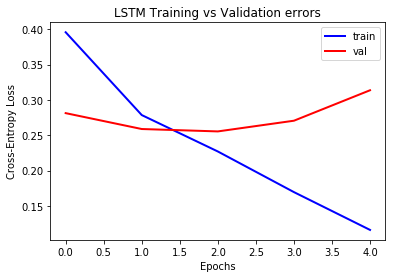

<Figure size 432x288 with 0 Axes>

In [26]:
plot_errors(history, "model_final.png")
# plot_errors(history_dropout, "model_dropout.png")

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss

def predict_tags(model, filename, threshold):
    y_predict = model.predict([X_te], batch_size=1024, verbose=1)
    y_predict = pd.DataFrame(y_predict)
    y_predict = y_predict.apply(lambda x: [0 if y <= threshold else 1 for y in x])
    y_predict.columns = list_classes
    file1 = open(filename+str(threshold),"w") 
    file1.write("threshold") 
    file1.write("\n") 
    file1.write("Classification Report\n") 
    print(classification_report(y_test, y_predict))
    file1.write(classification_report(y_test, y_predict)) 
    file1.write("Accuracy Score\n") 
    print(accuracy_score(y_test, y_predict))
    file1.write(str(accuracy_score(y_test, y_predict)))
    file1.write("Hamming Loss\n") 
    print(str(hamming_loss(y_test, y_predict)))
    file1.write(str(hamming_loss(y_test, y_predict)))
    file1.close()
    return y_predict

In [28]:
y_predict = predict_tags(model, "model_final.txt", 0.5)
# predict_tags(model_dropout, "model_dropout.txt")

3482/3482 [==============================] - 6s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.77      0.80      1630
           1       0.75      0.75      0.75      1077
           2       0.69      0.63      0.66       771
           3       0.76      0.71      0.73       768
           4       0.88      0.81      0.84       690
           5       0.85      0.80      0.83       596
           6       0.83      0.61      0.71       458

   micro avg       0.79      0.74      0.76      5990
   macro avg       0.80      0.73      0.76      5990
weighted avg       0.79      0.74      0.76      5990
 samples avg       0.81      0.78      0.77      5990

0.4867892016082711
0.11192254041191434


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [29]:
X_tet.reset_index(drop=True, inplace=True)
y_predict.reset_index(drop=True, inplace=True)
labels = [str(i) + '_real' for i in list_classes]
y_te.columns = labels
y_te.reset_index(drop=True, inplace=True)
final = pd.concat([X_tet, y_predict, y_te], axis = 1)
final.head()

,authors,url,title,content,img_src,startups,mobile,apps,social,gadgets,europe,enterprise,startups_real,mobile_real,apps_real,social_real,gadgets_real,europe_real,enterprise_real
0,Darrell Etherington,https://techcrunch.com/2014/11/17/yotaphone-2-...,YotaPhone 2 Dual-Screen Smartphone Gets Its De...,"Smartphones are mostly similar, barring differ...",https://tctechcrunch2011.files.wordpress.com/2...,0,1,0,0,1,0,0,0,1,0,0,1,0,0
1,Connie Loizos,https://techcrunch.com/2015/11/25/iguaz-io-lan...,Iguaz.io Lands $15 Million Series A,Herzliya Israel-based Iguaz.io isn’t yet sayin...,https://tctechcrunch2011.files.wordpress.com/2...,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,Romain Dillet,https://techcrunch.com/2015/11/30/amazon-video...,Amazon Video Might Be Coming To The Apple TV A...,After announcing that Amazon would stop sellin...,https://tctechcrunch2011.files.wordpress.com/2...,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,Frederic Lardinois,https://techcrunch.com/2016/03/16/googles-make...,Google’s latest mobile search algorithm update...,"If your site isn’t easy to use on mobile, Goog...",https://tctechcrunch2011.files.wordpress.com/2...,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,Anthony Ha,https://techcrunch.com/2012/08/14/unruly-tripl...,Social Video Company Unruly Triples Annual Rev...,"Unruly, a social video distribution platform w...",https://tctechcrunch2011.files.wordpress.com/2...,1,0,0,1,0,0,0,0,0,0,1,0,1,0


In [30]:
final['sum'] = y_predict.sum(axis = 1, skipna = True) 
final['sum_real'] = y_te.sum(axis = 1, skipna = True) 
final = final[final['sum'] > 2]
final = final[final['sum_real'] > 2]
final = final[(final.gadgets == 1) | (final.europe == 1) | (final.enterprise == 1)]
# final = final[['url','img_src','authors','title','content']]
# final.reset_index(drop=True, inplace=True)
# y_te.reset_index(drop=True, inplace=True)
# final = pd.concat([final, y_te],axis = 1)
print(final.shape)
blog_list = ['url','img_src','authors','title','content']
final = final[blog_list + labels]
final= final[['url','img_src','authors','title','content', 'startups_real', 'mobile_real', 'apps_real', 'social_real', 'gadgets_real', 'europe_real','enterprise_real']]
final.to_csv('demo_final.csv', sep='\t')
final.head(20)

(46, 21)


,url,img_src,authors,title,content,startups_real,mobile_real,apps_real,social_real,gadgets_real,europe_real,enterprise_real
22,https://techcrunch.com/2015/08/25/cyanogen-and...,https://tctechcrunch2011.files.wordpress.com/2...,Natasha Lomas,"Cyanogen OS Lands On Two New Smartphones, Targ...","The Cyanogen flavor of open Android, which is ...",0,1,0,0,1,1,0
41,https://techcrunch.com/2012/11/28/everything-m...,https://tctechcrunch2011.files.wordpress.com/2...,Ingrid Lunden,"Everything.me, The Search App That Bridges The...",Native apps are stealing the show when it come...,1,1,1,0,0,0,0
88,https://techcrunch.com/2013/10/17/coffee-house...,https://tctechcrunch2011.files.wordpress.com/2...,Steve O'Hear,Playlists.net Revamps iOS App To Focus On Musi...,Spotify community and playlist sharing site Pl...,1,1,0,0,0,1,0
226,https://techcrunch.com/2013/02/07/evernote-bus...,https://tctechcrunch2011.files.wordpress.com/2...,Ingrid Lunden,"Evernote, Now With Its First COO, Takes Its Pr...","Evernote, the popular personal information and...",0,1,1,0,0,1,1
246,https://techcrunch.com/2016/05/17/snips-is-a-p...,https://tctechcrunch2011.files.wordpress.com/2...,Romain Dillet,Snips is a personal assistant that combines al...,French startup Snips is launching its first pr...,1,1,0,0,0,1,0
266,https://techcrunch.com/2015/10/27/apple-finall...,https://tctechcrunch2011.files.wordpress.com/2...,Ingrid Lunden,"Apple Rolls Out Carrier Billing For iTunes, St...","At long last, Apple is adding a way for people...",0,1,1,0,0,1,0
312,https://techcrunch.com/2014/10/16/bbc-whatsapp...,https://tctechcrunch2011.files.wordpress.com/2...,Ingrid Lunden,BBC Uses WhatsApp For An Ebola Health Alert Se...,While Snapchat may reportedly be talking to a ...,0,1,1,0,0,1,0
506,https://techcrunch.com/2014/11/10/thingsee-one...,https://tctechcrunch2011.files.wordpress.com/2...,Natasha Lomas,Ex-Nokians Crowdfund A Device To Democratize T...,Nokia’s exit from the mobile making market ear...,0,0,1,0,1,1,0
742,https://techcrunch.com/2012/11/01/recce-3d-int...,https://tctechcrunch2011.files.wordpress.com/2...,Natasha Lomas,Recce 3D Interactive Mapping Tech Gets Its Gam...,"We wrote about Recce back in July: a rich, int...",1,1,1,0,0,1,0
805,https://techcrunch.com/2016/08/25/thingthing-i...,https://tctechcrunch2011.files.wordpress.com/2...,Natasha Lomas,ThingThing iOS keyboard app adds meeting invit...,Productivity focused third party iOS keyboard ...,1,0,1,0,0,1,0


In [31]:
# from sklearn.metrics import classification_report
# print(classification_report(y_test, y_predict))

In [32]:
# from sklearn.metrics import accuracy_score
# accuracy_score(y_test, y_predict)

In [33]:
# #Hamming loss
# from sklearn.metrics import hamming_loss
# hamming_loss(y_test, y_predict)

## Model1
### f1 score
### micro avg       0.77      0.70      0.73      5990
### macro avg       0.78      0.68      0.73      5990
### weigh avg       0.77      0.70      0.73      5990
### sampl avg       0.79      0.74      0.73      5990
### Accuracy score
0.4511774842044802
### Hamming loss
0.1250923114794453

## Model2 - Drop out
### f1 score
### micro avg       0.77      0.69      0.73      5990
### macro avg       0.78      0.68      0.72      5990
### weighted avg    0.77      0.69      0.73      5990
### samples avg     0.80      0.75      0.74      5990
### Accuracy score
0.44399770246984493
### Hamming loss
0.1253384754246328

In [34]:
list_classes

Index(['startups', 'mobile', 'apps', 'social', 'gadgets', 'europe',
       'enterprise'],
      dtype='object')